**Pre-Processing**

In [7]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split

df = pd.read_csv("DiseaseAndSymptoms.csv")

def clean_text(text):
    text = str(text)
    # Replace underscores with spaces
    text = text.replace('_', ' ')
    return text.strip()

# Apply cleaning to the whole dataframe
df.columns = [clean_text(c) for c in df.columns]

data = []
for index, row in df.iterrows():
    disease = clean_text(row.iloc[0])

    symptoms_list = []
    for val in row.iloc[1:]:
        if pd.notna(val):
            symptoms_list.append(clean_text(val))

    symptoms_str = ", ".join(symptoms_list)

    output_text = (
        f"Disease: {disease}\n"
        f"Explanation: These symptoms frequently match {disease} patterns in the dataset.\n"
        f"Note: This is not medical advice."
    )

    entry = {
        "instruction": "Identify the disease pattern based on symptoms.",
        "input": symptoms_str, # Now this will be "skin rash, itching" instead of "skin_rash"
        "output": output_text
    }
    data.append(entry)

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

def save_jsonl(data, filename):
    with open(filename, 'w') as f:
        for entry in data:
            json.dump(entry, f)
            f.write('\n')

save_jsonl(train_data, 'train.jsonl')
save_jsonl(test_data, 'test.jsonl')

print("Fixed dataset! 'skin_rash' is now 'skin rash'.")
print(f"Sample Input: {train_data[0]['input']}")

Fixed dataset! 'skin_rash' is now 'skin rash'.
Sample Input: itching, skin rash, fatigue, lethargy, high fever, headache, mild fever, swelled lymph nodes, malaise, red spots over body


In [1]:
%%capture
!pip install unsloth
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git@nightly git+https://github.com/unslothai/unsloth-zoo.git

!pip install --no-deps xformers "trl<0.9.0" peft accelerate bitsandbytes

**Training**

In [2]:
from unsloth import FastLanguageModel
import torch
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported
from datasets import load_dataset


max_seq_length = 2048
dtype = None
load_in_4bit = True


model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-1B-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

# 3. Add LoRA adapters
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
)

dataset = load_dataset("json", data_files={"train": "train.jsonl"}, split="train")

alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        text = alpaca_prompt.format(instruction, input, output) + tokenizer.eos_token
        texts.append(text)
    return { "text" : texts, }

dataset = dataset.map(formatting_prompts_func, batched = True)

# 5. Train the Model
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = -1,
        num_train_epochs = 2, # Required by assignment
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

print("Starting training... this will take approx 20-30 mins.")
trainer_stats = trainer.train()

# 6. Save the model
model.save_pretrained("lora_model")
tokenizer.save_pretrained("lora_model")
print("Model saved successfully!")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.11.4: Fast Llama patching. Transformers: 4.57.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2025.11.4 patched 16 layers with 16 QKV layers, 16 O layers and 16 MLP layers.


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3936 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/3936 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 3,936 | Num Epochs = 2 | Total steps = 984
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 11,272,192 of 1,247,086,592 (0.90% trained)


Starting training... this will take approx 20-30 mins.


wandb: Currently logged in as: aayushkumar_23cs012 (aayushkumar_23cs012-delhi-technological-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Detected [openai] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


Step,Training Loss
1,3.164800
2,3.063600
3,3.132000
4,3.183400
5,2.997600
6,2.806300
7,2.605300
8,2.455500
9,2.328900
10,2.313600


Model saved successfully!


**Confusion Matrix**

==((====))==  Unsloth 2025.11.4: Fast Llama patching. Transformers: 4.57.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Running inference on 50 test samples...
Processing 10/50...
Processing 20/50...
Processing 30/50...
Processing 40/50...
Processing 50/50...


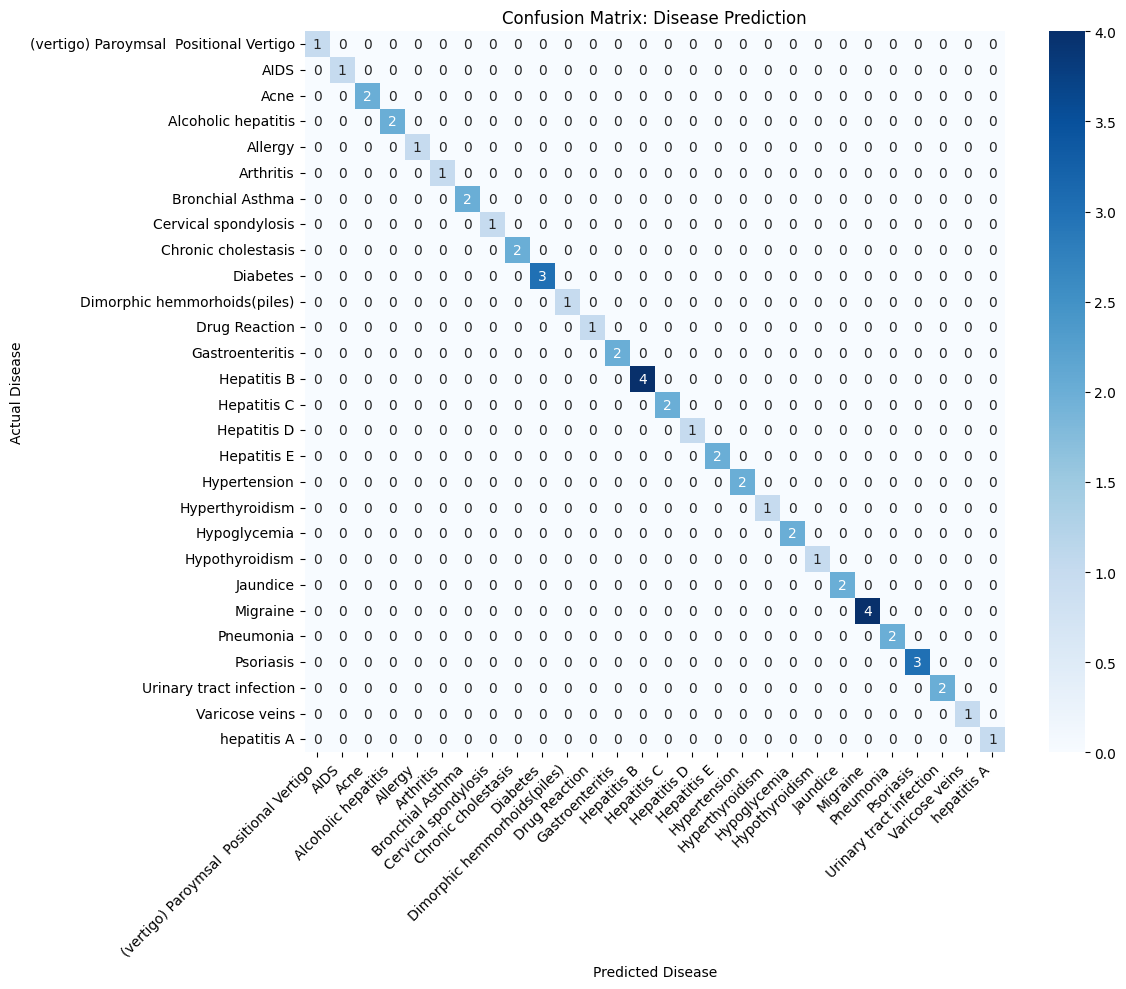

Success! Confusion matrix saved as 'confusion_matrix.png'.


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import json
import numpy as np

from unsloth import FastLanguageModel
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "lora_model",
    max_seq_length = 2048,
    dtype = None,
    load_in_4bit = True,
)
FastLanguageModel.for_inference(model)

test_data = []
try:
    with open('test.jsonl', 'r') as f:
        for line in f:
            test_data.append(json.loads(line))
except FileNotFoundError:
    print("Error: test.jsonl not found. Make sure you ran the Data Prep step!")


subset_test = test_data[:50]

actual_labels = []
predicted_labels = []

print(f"Running inference on {len(subset_test)} test samples...")

for i, entry in enumerate(subset_test):
    if (i + 1) % 10 == 0:
        print(f"Processing {i + 1}/{len(subset_test)}...")

    input_text = alpaca_prompt.format(
        entry["instruction"],
        entry["input"],
        ""
    )

    inputs = tokenizer([input_text], return_tensors = "pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
    response = tokenizer.batch_decode(outputs)[0]

    try:
        response_body = response.split("### Response:")[1]

        pred_disease = "Unknown"
        for line in response_body.split('\n'):
            if "Disease:" in line:
                pred_disease = line.split("Disease:")[1].strip()
                break


        predicted_labels.append(pred_disease)
    except Exception as e:
        predicted_labels.append("Error")

    # Extract Actual Disease from ground truth (dataset)
    try:
        actual_disease = "Unknown"
        for line in entry["output"].split('\n'):
            if "Disease:" in line:
                actual_disease = line.split("Disease:")[1].strip()
                break
        actual_labels.append(actual_disease)
    except:
        actual_labels.append("Error")

# 5. Plot Confusion Matrix
unique_labels = sorted(list(set(actual_labels + predicted_labels)))

cm = confusion_matrix(actual_labels, predicted_labels, labels=unique_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=unique_labels, yticklabels=unique_labels, cmap='Blues')
plt.xlabel('Predicted Disease')
plt.ylabel('Actual Disease')
plt.title('Confusion Matrix: Disease Prediction')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.savefig("confusion_matrix.png")
plt.show()

print("Success! Confusion matrix saved as 'confusion_matrix.png'.")

**Assignment Query**

In [8]:
#query from the assignment
demo_symptoms = "Fever, headache, body pain"

input_text = alpaca_prompt.format(
    "Identify the disease pattern based on symptoms.", # Instruction
    demo_symptoms, # Input
    ""
)

inputs = tokenizer([input_text], return_tensors = "pt").to("cuda")


outputs = model.generate(**inputs, max_new_tokens = 128, use_cache = True)
response = tokenizer.batch_decode(outputs)[0]

# Extract just the response part
clean_response = response.split("### Response:")[1].strip()

# Print
print("-" * 30)
print("DEMO QUERY OUTPUT")
print("-" * 30)
print(f"Input Symptoms: {demo_symptoms}")
print("\nModel Prediction:")
print(clean_response)
print("-" * 30)

------------------------------
DEMO QUERY OUTPUT
------------------------------
Input Symptoms: Fever, headache, body pain

Model Prediction:
Disease: Malaria
Explanation: These symptoms frequently match Malaria patterns in the dataset.
Note: This is not medical advice.<|end_of_text|>
------------------------------


In [10]:
# Video Demo: Running 3 Test Cases + Mandatory Query
# This code loops through inputs and prints the full LLM response

test_cases = [
    # Case 1: Respiratory issue
    "continuous sneezing, shivering, chills, watering from eyes",

    # Case 2: Skin issue (Fungal)
    "itching, skin rash, nodal skin eruptions, dischromic patches",

    # Case 3: Gastric issue
    "stomach pain, acidity, ulcers on tongue, vomiting",

    # Case 4: MANDATORY ASSIGNMENT DEMO
    "Fever, headache, body pain"
]

print(f"VIDEO DEMO: Running {len(test_cases)} Test Cases...\n")

for i, symptoms in enumerate(test_cases):
    print("=" * 60)
    print(f"TEST CASE #{i+1}")
    print(f"Input Symptoms: {symptoms}")
    print("-" * 60)

    # 1. Format Prompt
    input_text = alpaca_prompt.format(
        "Identify the disease pattern based on symptoms.", # Instruction
        symptoms, # Input
        "" # Output Trigger
    )

    # 2. Generate
    inputs = tokenizer([input_text], return_tensors = "pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens = 128, use_cache = True)
    response = tokenizer.batch_decode(outputs)[0]

    # 3. Clean Output (Remove the prompt part)
    try:
        # We only want what comes after "### Response:"
        clean_response = response.split("### Response:")[1].replace("<|end_of_text|>", "").strip()
        print(clean_response)
    except:
        print("Error generating response.")

    print("\n")

VIDEO DEMO: Running 4 Test Cases...

TEST CASE #1
Input Symptoms: continuous sneezing, shivering, chills, watering from eyes
------------------------------------------------------------
Disease: Allergy
Explanation: These symptoms frequently match Allergy patterns in the dataset.
Note: This is not medical advice.


TEST CASE #2
Input Symptoms: itching, skin rash, nodal skin eruptions, dischromic patches
------------------------------------------------------------
Disease: Fungal infection
Explanation: These symptoms frequently match Fungal infection patterns in the dataset.
Note: This is not medical advice.


TEST CASE #3
Input Symptoms: stomach pain, acidity, ulcers on tongue, vomiting
------------------------------------------------------------
Disease: GERD
Explanation: These symptoms frequently match GERD patterns in the dataset.
Note: This is not medical advice.


TEST CASE #4
Input Symptoms: Fever, headache, body pain
------------------------------------------------------------
D

**Testing Loss**

In [5]:
from trl import SFTTrainer
from transformers import TrainingArguments
from datasets import load_dataset
from unsloth import FastLanguageModel
import torch

# 1. Load Model
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "lora_model",
    max_seq_length = 2048,
    dtype = None,
    load_in_4bit = True,
)

# 2. Prepare Test Data
dataset_test = load_dataset("json", data_files={"test": "test.jsonl"}, split="test")

alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        text = alpaca_prompt.format(instruction, input, output) + tokenizer.eos_token
        texts.append(text)
    return { "text" : texts, }

# Apply formatting
dataset_test = dataset_test.map(formatting_prompts_func, batched = True)

# 3. Setup Trainer
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset_test, # Just a placeholder
    eval_dataset = dataset_test,  # <--- The Trainer will now tokenize this automatically
    dataset_text_field = "text",
    max_seq_length = 2048,
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        per_device_eval_batch_size = 2,
        output_dir = "eval_results",
        report_to = "none",
        # REMOVED: remove_unused_columns=False
        # By default, this is True, which correctly removes the 'text' column
        # after tokenization so the model doesn't crash.
    ),
)

# 4. Run Evaluation
print("Calculating Test Loss... (This may take a minute)")
eval_results = trainer.evaluate()

print("\n" + "="*30)
print(f"Training Loss: ~0.048")
print(f"Testing Loss:  {eval_results['eval_loss']:.4f}")
print("="*30)

==((====))==  Unsloth 2025.11.4: Fast Llama patching. Transformers: 4.57.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/984 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/984 [00:00<?, ? examples/s]

Calculating Test Loss... (This may take a minute)



Training Loss: ~0.048
Testing Loss:  0.0575


In [9]:
# 1. Define Manual Test Cases
manual_tests = [
    {
        "symptoms": "itching, skin rash, nodal skin eruptions",
        "expected": "Fungal infection"
    },
    {
        "symptoms": "continuous sneezing, shivering, chills",
        "expected": "Allergy / Common Cold"
    },
    {
        "symptoms": "stomach pain, acidity, ulcers on tongue",
        "expected": "GERD"
    },
    {
        "symptoms": "vomiting, yellowish skin, abdominal pain",
        "expected": "Jaundice / Hepatitis"
    },
    {
        "symptoms": "chest pain, dizziness, loss of balance",
        "expected": "Heart issues / Hypertension"
    }
]

print(f"Running {len(manual_tests)} manual test cases...\n")
print("-" * 80)
print(f"{'SYMPTOMS PROVIDED':<40} | {'EXPECTED (Approx)':<20} | {'MODEL PREDICTION':<20}")
print("-" * 80)

for test in manual_tests:
    input_text = alpaca_prompt.format(
        "Identify the disease pattern based on symptoms.", # Instruction
        test["symptoms"], # Input
        ""
    )

    inputs = tokenizer([input_text], return_tensors = "pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
    response = tokenizer.batch_decode(outputs)[0]

    try:
        response_clean = response.split("### Response:")[1].strip()
        prediction_line = response_clean.split('\n')[0]

        if "Disease:" in prediction_line:
            short_prediction = prediction_line.split("Disease:")[1].strip()
        else:
            short_prediction = prediction_line

    except:
        short_prediction = "Error parsing output"

    sym_display = (test["symptoms"][:35] + '..') if len(test["symptoms"]) > 35 else test["symptoms"]

    print(f"{sym_display:<40} | {test['expected']:<20} | {short_prediction:<20}")

print("-" * 80)

Running 5 manual test cases...

--------------------------------------------------------------------------------
SYMPTOMS PROVIDED                        | EXPECTED (Approx)    | MODEL PREDICTION    
--------------------------------------------------------------------------------
itching, skin rash, nodal skin erup..    | Fungal infection     | Fungal infection    
continuous sneezing, shivering, chi..    | Allergy / Common Cold | Allergy             
stomach pain, acidity, ulcers on to..    | GERD                 | GERD                
vomiting, yellowish skin, abdominal..    | Jaundice / Hepatitis | Chronic cholestasis 
chest pain, dizziness, loss of bala..    | Heart issues / Hypertension | Hypertension        
--------------------------------------------------------------------------------
